<a href="https://colab.research.google.com/github/christievanderuit/TM10007_group11/blob/main/TM10007_Group11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sklearn numpy matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn


# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [ ]:
# Some functions we will use
def colorplot(clf, ax, x, y, h=100):
    '''
    Overlay the decision areas as colors in an axes.
    
    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    if len(Z.shape) > 1:
        Z = Z[:, 1]
    
    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm

In [ ]:
# Run this to use from colab environment
!git clone https://github.com/jveenland/tm10007_ml.git
import os
import pandas as pd
data = pd.read_csv('/content/tm10007_ml/worcgist/GIST_radiomicFeatures.csv', index_col=0)
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

fatal: destination path 'tm10007_ml' already exists and is not an empty directory.
The number of samples: 246
The number of columns: 494


In [ ]:
#zorgen dat verschillende functies uit de files aangeroepen kunnen worden 
from tm10007_ml.worcgist.load_data import *   #misschien dat dit nog op een nettere manier kan 
dataset = load_data(); 

In [ ]:
#zoeken van NaN --> want duidelijk dat deze erin zitten - ook voor de nu geplotte in de eerste figuur 
x_data = data.drop("label", axis='columns')


np.where(np.asanyarray(np.isnan(x_data))) 

# # Find all entries that are not a number
x_data = x_data.apply(lambda x: pd.to_numeric(x, errors='coerce'))
nan_b = pd.isna(x_train)
n_nan = nan_b.sum().sum()
if n_nan > 0:
  nan = np.where(nan_b == "True")
else:
  nan = 0
# # Replace all NaN with 0
# x_train_nieuw = x_train.fillna(0)
print(n_nan)

# volgens mij hebben wij dus alleen rijen waarbij er opeens 0'en zijn, maar 
# hebben wij geen Nan 
#op deze manier worden in x_train alle kolommen gevonden waarbij er alleen maar 
#0'en zijn, dus deze droppen - dit zijn 6 kolommen 
df1 = x_data.mask(x_data != 0).dropna(axis=1)
# print(df1)

#zorgen dat deze rijen verwijderd worden ? willen we dit ?  NOG NIET GELUKT :)
# column_names = list(df1.columns.values)
# df2 = x_train.drop('index', inplace=True, axis=1)

df1 = x_data.mask(x_data != 0).dropna(axis=1)

df2 = x_data.copy()
for col in df1:
    df2 = df2.drop(col, axis=1)

#print(df2)

0


In [ ]:
#Splitsen in een train en in een testset 

# Classifiers
from sklearn.model_selection import train_test_split

#Waarbij x = features, y = label
#vraag: doet ie dit elke keer op een andere manier? want dan toch lastig conclusies te trekken? --> daarom achter random state een getal - maakt niet uit zolang integer is
y = data['label']
x = df2
# df_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=1, stratify=y)
#AFBLIJVEN VAN TESTDATA!! :) 





In [ ]:
# testen of er outliers zijn dmv LOF
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()
x_lof = lof.fit(x_train)
outlier_scores = x_lof.negative_outlier_factor_
threshold = np.mean(outlier_scores)
outliers = x_train[outlier_scores < threshold]
outlier_percentage = (len(outliers) / len(x_train)) * 100

print("Number of outliers:", len(outliers))
print("Percentage of outliers:", outlier_percentage)

In [ ]:
#Testen of de data normaal verdeeld is of niet 
from scipy.stats import shapiro
  
# define a function to test for normality using the Shapiro-Wilk test
def test_normality(column):
    stat, p = shapiro(column)
    alpha = 0.05
    if p > alpha:
        return 1
    else:
        return 0

# apply the test_normality function to each column of the DataFrame
normality_results = x_train.apply(test_normality)

# print the results
print(normality_results)
# sum = sum(normality_results)
print(sum)

#dus meeste data is niet normaal verdeeld voor 60 van de gevallen --> dus voor deze wil je 
#een andere schaling gaan toepassen 

# losse dataframes maken 
normalized = pd.DataFrame()
non_normalized = pd.DataFrame()
for ind, elem in zip(x_train.columns, normality_results): 
  if elem == 0: 
    non_normalized = non_normalized.append(x_train[ind])
  else: 
    normalized = normalized.append(x_train[ind])

  

#los scalen 
scaler = preprocessing.RobustScaler()
scaler.fit(non_normalized)
non_normalized = pd.DataFrame(scaler.transform(non_normalized))

scaler_norm = preprocessing.StandardScaler()
scaler_norm.fit(normalized)
normalized = pd.DataFrame(scaler_norm.transform(normalized))

#non_normalized en normalized gecombineerd in een nieuwe dataframe
# x_train_scaled = pd.concat([non_normalized, normalized])
# scaler_tot = preprocessing.MinMaxScaler()
# scaler_tot.fit(x_train_scaled)
# x_train_scaled = pd.DataFrame(scaler_tot.transform(x_train_scaled))
# x_train_scaled = x_train_scaled.transpose()
scaler.fit(x_train)
x_scaled = pd.DataFrame(scaler.transform(x_train))

#x_train_scaled = normalized.append(non_normalized)
# 1. losse df voor normalized en non normalized 
# 2. scaling met Robust en Standard 
# 3. Samenvoegen en alles met Min max normalizeren 


PREDICT_original_sf_compactness_avg_2.5D                  0
PREDICT_original_sf_compactness_std_2.5D                  0
PREDICT_original_sf_rad_dist_avg_2.5D                     0
PREDICT_original_sf_rad_dist_std_2.5D                     0
PREDICT_original_sf_roughness_avg_2.5D                    0
                                                         ..
PREDICT_original_phasef_phasesym_kurtosis_WL3_N5          0
PREDICT_original_phasef_phasesym_range_WL3_N5             0
PREDICT_original_phasef_phasesym_energy_WL3_N5            0
PREDICT_original_phasef_phasesym_quartile_range_WL3_N5    0
PREDICT_original_phasef_phasesym_entropy_WL3_N5           1
Length: 487, dtype: int64
<built-in function sum>


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
            PREDICT_original_sf_compactness_avg_2.5D  \
ID                                                     
GIST-083_0                                  0.371705   
GIST-133_0                                  0.796716   
GIST-145_0                                  0.826348   
GIST-001_0                                  0.797427   
GIST-139_0                                  0.894811   
...                                              ...   
GIST-185_0                                  0.814293   
GIST-032_0                                  0.868296   
GIST-080_0                                  0.689300   
GIST-089_0                                  0.859021   
GIST-211_0                                  0.562105   

            PREDICT_original_sf_compactness_std_2.5D  \
ID                                                     
GIST-083_0                                  0.316183   
GIST-133_0                     

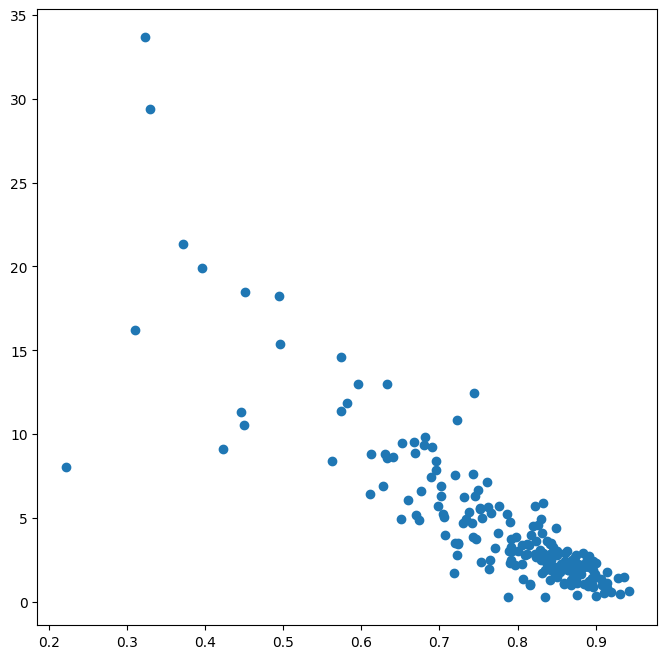

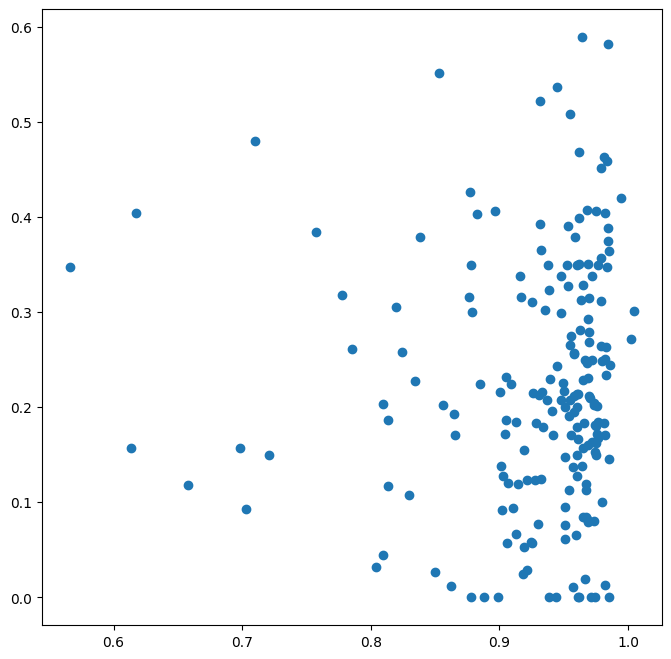

In [ ]:
#plotten 

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
print(type(x_train['PREDICT_original_hf_min']))
plt.scatter(x_train['PREDICT_original_sf_compactness_avg_2.5D'], x_train['PREDICT_original_sf_roughness_std_2.5D'])
# plt.show()

#Testen met een andere variabele 
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
print(type(x_train['PREDICT_original_hf_min']))
plt.scatter(x_train['PREDICT_original_sf_convexity_avg_2.5D'], x_train['PREDICT_original_phasef_phasesym_range_WL3_N5'])
# plt.show()

print(x_train)

In [ ]:
# Attempt at PCA

def pca_func(X,n):
  # create PCA object with 2 components
  pca = PCA(n_components=n)

  # fit and transform the data
  df_pca = pca.fit_transform(X)
  return df_pca

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

def kbest_func(X, k):
    """
    Select the top k features using the f_regression score as the evaluation metric
    """
    # define the feature selector
    selector = SelectKBest(score_func=f_regression, k=k)
    
    # fit the selector to the training data and transform the data
    x_train_kbest = selector.fit_transform(X, y_train)
    
    return x_train_kbest


In [ ]:
# RFE

def rfe_func(X,k):
    # linear regression
    lr = LinearRegression()

    # Create an RFE object and select the top n features (we moeten misschien nog even letten op de step)
    rfe = RFE(estimator=lr, n_features=k, step=1)
  
    #fit and transform the data
    df_rfe = rfe.fit_transform(X)
    return df_rfe

In [ ]:
# L1 regularization (Lasso regression)

def lasso_func(X,c): 
    #lasso regression
    lasso = Lasso(alpha=c)

    #fit and transform the data
    df_lasso = lasso.fit_transform(X)
    return df_lasso

In [ ]:
# SVM with cross vallidation

from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC

n = 50
x_pca = pca_func(x_scaled,n)

y_gist = pd.Series([1 if label == "GIST" else 0 for label in y_train], index=y_train.index)


# Create a linear SVM object
svm = LinearSVC(max_iter=1000)

# Perform 5-fold cross-validation on the training data
scores = cross_val_score(svm, x_pca, y_gist, cv=50)

# Print the average accuracy and standard deviation of the cross-validation scores
print("Accuracy: {:.2f}% (+/- {:.2f}%)".format(scores.mean()*100, scores.std()*100))


Accuracy: 49.33% (+/- 13.11%)


In [ ]:
# KNN poging
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

n = 50
x_pca = pca_func(x_scaled,n)

# Assume X_train, y_train are numpy arrays or pandas dataframes
# Create a k-NN classifier object with k=5
knn = KNeighborsClassifier(n_neighbors=9)

# Use 5-fold cross-validation to evaluate the performance of the k-NN classifier on the training set
scores = cross_val_score(knn, x_pca, y_gist, cv=100)

# Print the cross-validation scores and their mean
print("Accuracy: {:.2f}% (+/- {:.2f}%)".format(scores.mean()*100, scores.std()*100))


Accuracy: 48.00% (+/- 36.69%)


In [ ]:
# Non linear SVM
from sklearn.svm import SVC

n = 100
x_pca = pca_func(x_scaled,n)

# Train non-linear SVM with cross-validation
clf = SVC(kernel='poly',degree=3, C=1.0)
scores = cross_val_score(clf, x_pca, y_train, cv=100)

# Print cross-validation scores
print("Accuracy: {:.2f}% (+/- {:.2f}%)".format(scores.mean()*100, scores.std()*100))


Accuracy: 52.00% (+/- 12.08%)
